#### 概要

予測部門では, 英語圏の求人情報に含まれるテキストデータ（職務内容に関する記述）をもとに, 職種を予測するアルゴリズムを作成していただきます.
今回用いる評価尺度はF1Score(マクロ平均)です. F1ScoreとはPrecisionとRecallの調和平均であり, 全クラスのF1Scoreの平均を取ることでF1Score(マクロ平均)が算出されます.
テストデータに対するF1Score(マクロ平均)をなるべく大きくするモデルを作ることが今回の目的です.
このチュートリアルでは古典的な自然言語処理の手法であるBag of Wordsを用いて特徴量を作成し, 勾配ブースティング決定木のアルゴリズムの1つであるXGBoostを用いてモデリングを行なっています.
これをきっかけに, 今まで自然言語処理に馴染みのなかった方も是非モデリングに取り組んでみてください.

### データの読み込みとEDA

まずはデータの読込や可視化に必要なライブラリをインポートします

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

学習用データ(train.csv)と評価用データ(test.csv)を読み込み, 中身を確認してみます

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#学習用データと評価用データの読み込み
train = pd.read_csv("/content/drive/MyDrive/Competition/SIGNATE/Datascientist/data/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Competition/SIGNATE/Datascientist/data/test.csv")

In [ ]:
#データのサイズ確認
print(train.shape)
print(test.shape)

(1516, 3)
(1517, 2)


In [ ]:
#学習用データの中身を確認
train.head()

,id,description,jobflag
0,0,<li>Develop cutting-edge web applications that...,3
1,1,"<li> Designs and develops high quality, scalab...",3
2,2,<li>Functions as a point person for Network St...,4
3,3,"<li> Work on the technical design, development...",3
4,4,<li>Quantify the resources required for a task...,4


In [ ]:
#評価用データの中身を確認
test.head()

,id,description
0,1516,<li>Building decision-making models and propos...
1,1517,<li>Educate homeowners on the benefits of sola...
2,1518,"<li><span>Design, develop, document, and imple..."
3,1519,<li>Apply advanced technical expertise and ski...
4,1520,<li>Project manage and deliver against our roa...


次に学習用データに含まれる, 職業ラベル（jobflag）のデータ数を確認してみます

4    505
1    468
3    455
2     88
Name: jobflag, dtype: int64


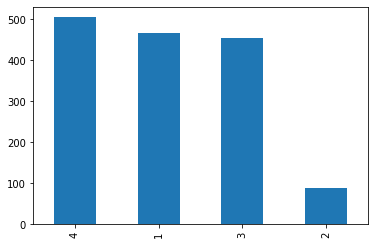

In [ ]:
#学習用データに含まれるjobflagをカウント（＋可視化）
print(train['jobflag'].value_counts())
train['jobflag'].value_counts().plot(kind = 'bar')

職種はConsultant(jobflag=4)が最も多く, Machiner learning engieer(jobflag=2)が最も少なくなっています.

続いて, descriptionに含まれる文字の長さも確認してみましょう.

In [ ]:
#学習用データ, 評価用データのdescriptionに含まれる文字数を確認
train_length = train['description'].str.len()
test_length = test['description'].str.len()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


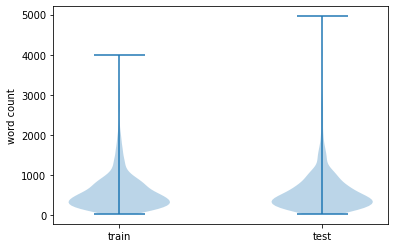

In [ ]:
#可視化
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.violinplot([train_length, test_length])
ax.set_xticks([1, 2])
ax.set_xticklabels(['train', 'test'])
ax.set_ylabel('word count')
plt.show()

descriptionの文字数は, 数十文字から数千字までとばらつきがありますが, 概ね500文字前後の文字数が多くなっています.
学習用データの職業ラベル(jobflag)ごとの文字数も合わせて確認してみましょう.

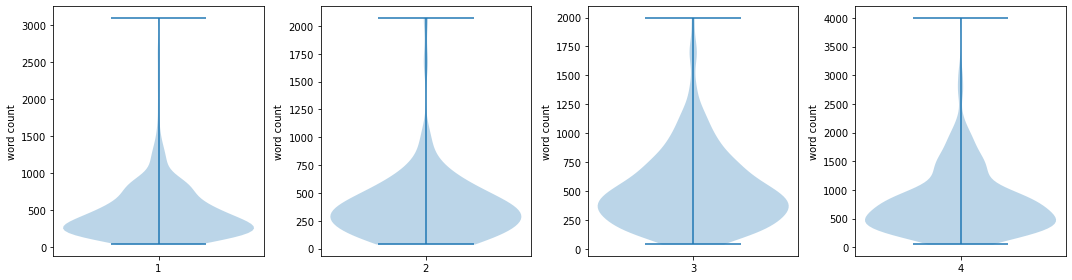

In [ ]:
#学習用データの職業ラベル(jobflag)ごとの文字数を確認
fig = plt.figure(figsize = (15, 4))
for flag in [1, 2, 3, 4]:
    train_length_flag = train[train['jobflag'] == flag]['description'].str.len()
    ax = fig.add_subplot(1, 4, flag)
    ax.violinplot(train_length_flag)
    ax.set_xticks([1])
    ax.set_xticklabels([flag])
    ax.set_ylabel('word count')
plt.tight_layout()
plt.show()

#### 前処理

続いてデータの前処理（クリーニング）を行います.
ここでは, 不要文字（アルファベット以外の文字）や3文字以下の単語の除去, およびステミング（単語の語幹を取り出す作業のこと. 派生語を同じ単語として扱えるようにする）を行います.
学習用データと評価用データのdescriptionを一括処理するため, 一度データを結合した上でクリーニングを行っていきます.

In [ ]:
#学習用データと評価用データを結合する (両データに対し一括で前処理を行うため)
combined = train.append(test, ignore_index=True)

In [ ]:
#以下の手順でdescriptionデータのクリーニングを行う.
# <li>などのhtmlタグを削除する
# アルファベット以外の文字をスペースに置き換える
# 単語長が3文字以下のものは削除する
# ステミング（単語の語幹を取り出す作業のこと. 派生語を同じ単語として扱えるようにする）

import re
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

def cleaning(texts):
    clean_texts = []
    for text in texts:
        # htmlタグを削除
        text = remove_tag(text)
        #アルファベット以外をスペースに置き換え
        clean_punc = re.sub(r'[^a-zA-Z]', ' ', text)
        #単語長が3文字以下のものは削除する
        clean_short_tokenized = [word for word in clean_punc.split() if len(word) > 3]
        #ステミング
        clean_normalize = [stemmer.stem(word) for word in clean_short_tokenized]
        #単語同士をスペースでつなぎ, 文章に戻す
        clean_text = ' '.join(clean_normalize)
        clean_texts.append(clean_text)
    return clean_texts

def remove_tag(x):
    p = re.compile(r"<[^>]*?>")
    return p.sub('',x)

combined_cleaned = combined.copy()
combined_cleaned['description'] = cleaning(combined['description'])

In [ ]:
# クリーニング結果の確認
print('#original\n', combined['description'][0])
print("-----")
print('#cleaned\n', combined_cleaned['description'][0])

#original
 <li>Develop cutting-edge web applications that perform superbly across all platforms.</li><li>Work in a highly collaborative environment with cross-functional teams on projects ranging from a few weeks to a few months in length.</li><li>Maintain high standard of quality as you creatively and strategically problem solve throughout the product delivery process.</li><li>Be able to effectively communicate your work with both technical and non-technical peers</li><li>Be excited about new web technologies/techniques</li><li>Build solid front-end architectures that integrate easily with other systems and technologies</li><li>Working closely with other disciplines (Back-end, UX, Design, QA)</li><li>Have a superior attention to detail and a strong ability to Q/A one\'s own work required, including cross-browser and cross-platform displays and performance</li></ul>
-----
#cleaned
 develop cut edg applic that perform superbl across platform work highli collabor environ with cross funct

タグや文字長3文字以下の単語が除去され, 単語の語幹が抽出されていることが分かります.
次に, このクリーニング済みのデータに対して, Bag of Words (文章中の単語の登場回数をカウントし, 特徴量化する手法)を適用して, descriptionをベクトル化します.

In [ ]:
#bag of words(文章中の単語の登場回数をカウントし, 特徴量化する手法)を用いて、descriptionをベクトル化する

from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=2000, stop_words='english')
bow = bow_vectorizer.fit_transform(combined_cleaned['description'])
print(bow.shape)

(3033, 2000)


#### モデリング

今回は, 勾配ブースティング決定木のアルゴリズムの1つで, オープンソースのライブラリが公開されているXGBoostを用いてモデリングを行います.
投稿前の精度検証では, ホールドアウト法を用いて学習用データの70%をモデルの学習に、残り30%を精度検証用に使いたいと思います.

In [ ]:
#学習用データを分割して, 投稿前の精度検証を行う

from sklearn.model_selection import train_test_split

delimit_num = train.shape[0]
train_bow = bow[:delimit_num, :]
test_bow = bow[delimit_num:, :]

x_bow_train, x_bow_valid, y_bow_train, y_bow_valid = train_test_split(train_bow, train['jobflag'], test_size=0.3, random_state=0)

In [ ]:
#XGBを用いて分類器を作成し、学習・予測を行う

from xgboost import XGBClassifier

mod = XGBClassifier(max_depth=6, n_estimators=1000, n_jobs=-1)
mod.fit(x_bow_train, y_bow_train)
pred = mod.predict(x_bow_valid)


#### 予測結果の可視化

              precision    recall  f1-score   support

           1      0.592     0.679     0.633       137
           2      0.429     0.136     0.207        22
           3      0.806     0.719     0.760       139
           4      0.701     0.745     0.722       157

    accuracy                          0.688       455
   macro avg      0.632     0.570     0.581       455
weighted avg      0.687     0.688     0.682       455



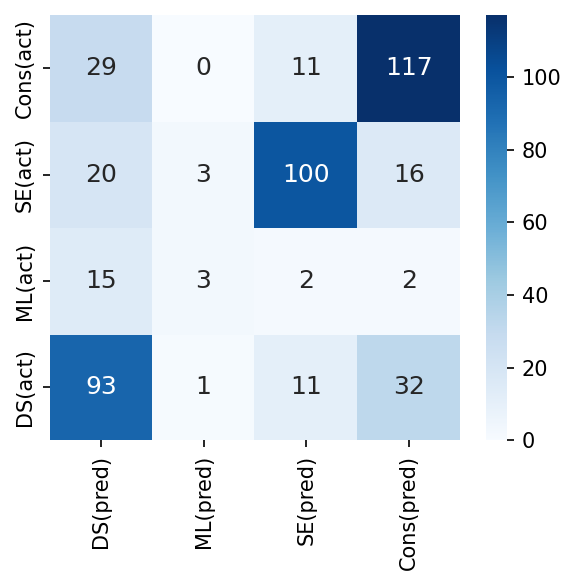

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
labels = [1, 2, 3, 4]
re_labels = ["DS", "ML", "SE", "Cons"]

#混同行列の作成
conf_mx = confusion_matrix(y_bow_valid, pred, labels=labels)
conf_df = pd.DataFrame(data=conf_mx, index=[x + "(act)" for x in re_labels], columns=[x + "(pred)" for x in re_labels])

#可視化
plt.figure(figsize=(4, 4), dpi=150)
sns.heatmap(conf_df, cmap='Blues', annot=True, fmt='d', annot_kws={"size": 12}).invert_yaxis()
plt.tight_layout()
 
print(classification_report(y_bow_valid, pred, labels=labels, digits=3))

予測結果を見ると、
・「Software engineer (jobflag=3)」は比較的上手く判別ができている
・「Machine learning engieer(jobflag=2)」は、「Data Scientist (jobflag=1)」と誤判定しているケースが多い

今回は, 古典的な手法(BoW)を用いて特徴量生成⇒モデル学習を行いましたが,
これらの誤判定を抑制しさらに精度を改善するために,
TF-IDFやWord2Vecといった特徴量生成, あるいはBERT（Bidirectional Encoder Representations from Transformers)といった最新の自然言語処理モデルに挑戦するのも良いでしょう.

#### 投稿用ファイルの作成

改めて学習用データ(train)全体を使って学習し, 評価用データ(test)に対して予測を行います.

In [ ]:
mod.fit(train_bow, train['jobflag'])
pred_sub = mod.predict(test_bow)

コンペ投稿用のファイルは, id列とjobflag列(予測結果)の2列で, ヘッダなしの形で作成します.

In [ ]:
sample_submit_df = pd.DataFrame([test['id'], pred_sub]).T
sample_submit_df.to_csv('./sample.csv', header=None, index=None)

#### まとめ

本チュートリアルでは, Bag of Wordsによる特徴抽出⇒モデル学習という古典的な手法でモデリングを試してきました.
一部の職種（Software Engineer）では今回の手法でも比較的上手く判別ができましたが, Machine learning engineerをはまだ誤判定が多くなっています.
さらなるスコア改善に向けて, 判別が難しい職種固有の特徴量の探索やより最新のモデリング手法など, 様々な改善策を試して学生チャンピオンを目指して下さい！！

おわり